In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

2022-09-06 13:32:41.060283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 13:32:41.060360: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import os

# Defining paths

In [3]:
train_path = "/home/skoooty/code/skoooty/job-prepr-data/train/train"

In [70]:
test_path = "/Users/andrei/code/images/images/validation"

In [ ]:
val_path = "~/code/images/images/val"

# Loading the images

In [4]:
# iterate through the names of contents of the folder
all_images = []
y_train = []
X_train = []
for folder_path in os.listdir(train_path):
    if not folder_path.startswith("."):
        for image_path in os.listdir(os.path.join(train_path, folder_path)):
            img = load_img(os.path.join(os.path.join(train_path, folder_path), image_path), color_mode = "grayscale")
            X_train.append(img_to_array(img))
            y_train.append(os.path.basename(os.path.normpath(folder_path)))

In [10]:
y_train = np.array(y_train)

In [11]:
X_train = np.array(X_train)

## Test


In [71]:
# iterate through the names of contents of the folder
all_images = []
y_test = []
X_test = []

for folder_path in os.listdir(test_path):
    if not folder_path.startswith("."):
        for image_path in os.listdir(os.path.join(test_path, folder_path)):
            img = load_img(os.path.join(os.path.join(test_path, folder_path), image_path), color_mode = "grayscale")
            X_test.append(img_to_array(img))
            y_test.append(os.path.basename(os.path.normpath(folder_path)))

In [73]:
y_test = np.array(y_test)

In [74]:
X_test = np.array(X_test)

# Investigation and baseline

In [5]:
y_train_df = pd.DataFrame(y_train)

In [6]:
y_label_dict = {
    'angry':0,
    'disgust':1,
    'fear':2,
    'happy':3,
    'neutral':4,
    'sad':5,
    'surprise':6
}


In [13]:
y_train_df_num = y_train_df.applymap(lambda x : y_label_dict[x])
np.array(y_train_df_num).shape

(28821, 1)

In [76]:
y_test_df = pd.DataFrame(y_test)

In [28]:
y_train_df.value_counts(normalize=True)

happy       0.248569
neutral     0.172860
sad         0.171333
fear        0.142361
angry       0.138545
surprise    0.111204
disgust     0.015128
dtype: float64

In [77]:
y_test_df.value_counts(normalize=True)

happy       0.258279
neutral     0.172092
sad         0.161194
fear        0.144070
angry       0.135862
surprise    0.112794
disgust     0.015709
dtype: float64

In [32]:
baseline = y_train_df.value_counts(normalize=True).max()

In [33]:
baseline

0.2485687519517019

In [12]:
X_train.shape

(28821, 48, 48, 1)

In [13]:
X_test.shape

NameError: name 'X_test' is not defined

# Preprocessing

In [14]:
from sklearn.preprocessing import OneHotEncoder

In [15]:
ohe = OneHotEncoder(sparse = False)

In [16]:
y_train_reshaped = y_train.reshape(-1, 1)

In [17]:
y_test_reshaped = y_test.reshape(-1, 1)

NameError: name 'y_test' is not defined

In [18]:
y_train_cat = ohe.fit_transform(y_train_reshaped)

In [19]:
y_test_cat = ohe.transform(y_test_reshaped)

NameError: name 'y_test_reshaped' is not defined

In [ ]:
ohe.get_feature_names_out()

In [ ]:
y_train_cat

In [20]:
X_train.shape

(28821, 48, 48, 1)

In [21]:
from sklearn.utils import shuffle

In [22]:
X_shuffle, y_shuffle = shuffle(X_train, y_train_cat, random_state = 0)

In [23]:
X_sample = X_shuffle[:3000, :, :, :]

In [24]:
y_sample = y_shuffle[:3000]

# Model

In [25]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import layers, models

model = models.Sequential()

# Notice this cool new layer that "pipe" your rescaling within the architecture
model.add(Rescaling(1./255, input_shape=(48, 48, 1)))

# Lets add 3 convolution layers, with relatively large kernel size as our pictures are quite big too
model.add(layers.Conv2D(16, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling2D(3))

model.add(layers.Conv2D(32, kernel_size=3, activation="relu"))
model.add(layers.MaxPooling2D(3))

model.add(layers.Conv2D(32, kernel_size=2, activation="relu"))
model.add(layers.MaxPooling2D(3))

model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

2022-09-06 13:34:06.393992: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-06 13:34:06.394064: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-06 13:34:06.394108: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-BAEIOTT): /proc/driver/nvidia/version does not exist
2022-09-06 13:34:06.394384: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 44, 44, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          4

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
model.fit(X_sample, y_sample, batch_size = 32, epochs = 1000,
          callbacks=[EarlyStopping(patience = 20, restore_best_weights= True, monitor = "val_accuracy", mode = "max")],
         validation_split = 0.2, verbose = 1)

Epoch 1/1000
75/75 [==============================] - 4s 41ms/step - loss: 1.8366 - accuracy: 0.2433 - val_loss: 1.8140 - val_accuracy: 0.2400
Epoch 2/1000
75/75 [==============================] - 2s 33ms/step - loss: 1.8164 - accuracy: 0.2492 - val_loss: 1.8090 - val_accuracy: 0.2400
Epoch 3/1000
75/75 [==============================] - 3s 34ms/step - loss: 1.8147 - accuracy: 0.2492 - val_loss: 1.8142 - val_accuracy: 0.2400
Epoch 4/1000
75/75 [==============================] - 3s 36ms/step - loss: 1.8111 - accuracy: 0.2492 - val_loss: 1.8104 - val_accuracy: 0.2400
Epoch 5/1000
75/75 [==============================] - 3s 37ms/step - loss: 1.8098 - accuracy: 0.2496 - val_loss: 1.8078 - val_accuracy: 0.2400
Epoch 6/1000
75/75 [==============================] - 3s 37ms/step - loss: 1.8035 - accuracy: 0.2458 - val_loss: 1.8009 - val_accuracy: 0.2550
Epoch 7/1000
75/75 [==============================] - 3s 35ms/step - loss: 1.7976 - accuracy: 0.2446 - val_loss: 1.7984 - val_accuracy: 0.2583

KeyboardInterrupt: 

In [81]:
model.evaluate(X_test, y_test_cat)

221/221 [==============================] - 1s 2ms/step - loss: 1.7549 - accuracy: 0.3627


[1.7548847198486328, 0.36272290349006653]

# GridSearch

In [51]:
def compile_model(maxpooling2d=2, activation_for_hidden='relu', last_dense_layer_neurons=100):
    from tensorflow.keras.layers.experimental.preprocessing import Rescaling
    from tensorflow.keras import layers, models

    model = models.Sequential()

    # Notice this cool new layer that "pipe" your rescaling within the architecture
    model.add(Rescaling(1./255, input_shape=(48, 48, 1)))

    # Lets add 3 convolution layers, with relatively large kernel size as our pictures are quite big too
    model.add(layers.Conv2D(16, kernel_size=5, activation=activation_for_hidden))
    model.add(layers.MaxPooling2D(maxpooling2d))

    model.add(layers.Conv2D(32, kernel_size=3, activation="relu"))
    model.add(layers.MaxPooling2D(maxpooling2d))

    model.add(layers.Conv2D(32, kernel_size=2, activation="relu"))
    model.add(layers.MaxPooling2D(maxpooling2d))

    model.add(layers.Flatten())
    model.add(layers.Dense(last_dense_layer_neurons, activation='relu'))
    model.add(layers.Dense(7, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [52]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

disguised_deep_model = KerasClassifier(build_fn = compile_model, 
                                       epochs = 1000, 
                                       batch_size = 32, 
                                       verbose = 0)

/tmp/ipykernel_24744/2305196919.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  disguised_deep_model = KerasClassifier(build_fn = compile_model,


In [48]:
from sklearn.pipeline import make_pipeline

In [49]:
pipeline = make_pipeline(disguised_deep_model)
pipeline

Pipeline(steps=[('kerasclassifier',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f8d45e6be20>)])

In [50]:
pipeline.get_params()

{'memory': None,
 'steps': [('kerasclassifier',
   <keras.wrappers.scikit_learn.KerasClassifier at 0x7f8d45e6be20>)],
 'verbose': False,
 'kerasclassifier': <keras.wrappers.scikit_learn.KerasClassifier at 0x7f8d45e6be20>,
 'kerasclassifier__epochs': 1000,
 'kerasclassifier__batch_size': 32,
 'kerasclassifier__verbose': 0,
 'kerasclassifier__build_fn': <function __main__.compile_model(maxpooling2d, activation_for_hidden='relu', last_dense_layer_neurons=100)>}

In [ ]:
from sklearn.model_selection import GridSearchCV

gridsearch_params = {
    # total number of combinations: 1296
    #optimizer : ["adam"],
    maxpooling2d : [2, 3, 4],
    kerasclassifier__activation_for_hidden : ["relu", "tanh"],
    #kernel_size : [(3, 3)],
    kerasclassifier__last_dense_layer_neurons : [80, 90, 100, 110, 120],
    kerasclassifier__batch_size : [8, 16, 32, 64],
    earlystopping_patience : [50]
}

# Fitting on all of the data

In [82]:
X_shuffle_all, y_shuffle_all = shuffle(X_train, y_train_cat, random_state = 0)

In [84]:
model2 = models.Sequential()

# Notice this cool new layer that "pipe" your rescaling within the architecture
model2.add(Rescaling(1./255, input_shape=(48, 48, 1)))

# Lets add 3 convolution layers, with relatively large kernel size as our pictures are quite big too
model2.add(layers.Conv2D(16, kernel_size=5, activation='relu'))
model2.add(layers.MaxPooling2D(3))

model2.add(layers.Conv2D(32, kernel_size=3, activation="relu"))
model2.add(layers.MaxPooling2D(3))

model2.add(layers.Conv2D(32, kernel_size=2, activation="relu"))
model2.add(layers.MaxPooling2D(3))

model2.add(layers.Flatten())
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(7, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [85]:
model2.fit(X_shuffle_all, y_shuffle_all, batch_size = 32, epochs = 1000,
          callbacks=[EarlyStopping(patience = 50, restore_best_weights= True, monitor = "val_accuracy", mode = "max")],
         validation_split = 0.2, verbose = 1)

Epoch 1/1000
721/721 [==============================] - 10s 13ms/step - loss: 1.8038 - accuracy: 0.2529 - val_loss: 1.7624 - val_accuracy: 0.2697
Epoch 2/1000
721/721 [==============================] - 9s 13ms/step - loss: 1.7019 - accuracy: 0.3066 - val_loss: 1.6681 - val_accuracy: 0.3334
Epoch 3/1000
721/721 [==============================] - 9s 12ms/step - loss: 1.6201 - accuracy: 0.3546 - val_loss: 1.6313 - val_accuracy: 0.3480
Epoch 4/1000
721/721 [==============================] - 9s 12ms/step - loss: 1.5476 - accuracy: 0.3931 - val_loss: 1.5532 - val_accuracy: 0.3960
Epoch 5/1000
721/721 [==============================] - 10s 13ms/step - loss: 1.4885 - accuracy: 0.4220 - val_loss: 1.4931 - val_accuracy: 0.4232
Epoch 6/1000
721/721 [==============================] - 9s 13ms/step - loss: 1.4408 - accuracy: 0.4435 - val_loss: 1.4570 - val_accuracy: 0.4418
Epoch 7/1000
721/721 [==============================] - 10s 13ms/step - loss: 1.4035 - accuracy: 0.4568 - val_loss: 1.4306 - val

Epoch 57/1000
721/721 [==============================] - 10s 13ms/step - loss: 1.0038 - accuracy: 0.6151 - val_loss: 1.4355 - val_accuracy: 0.4848
Epoch 58/1000
721/721 [==============================] - 9s 13ms/step - loss: 1.0031 - accuracy: 0.6153 - val_loss: 1.4141 - val_accuracy: 0.5051
Epoch 59/1000
721/721 [==============================] - 9s 13ms/step - loss: 0.9990 - accuracy: 0.6175 - val_loss: 1.4716 - val_accuracy: 0.4857
Epoch 60/1000
721/721 [==============================] - 9s 13ms/step - loss: 0.9960 - accuracy: 0.6207 - val_loss: 1.4360 - val_accuracy: 0.4958
Epoch 61/1000
721/721 [==============================] - 9s 13ms/step - loss: 0.9907 - accuracy: 0.6233 - val_loss: 1.4418 - val_accuracy: 0.4973
Epoch 62/1000
721/721 [==============================] - 9s 13ms/step - loss: 0.9889 - accuracy: 0.6236 - val_loss: 1.5077 - val_accuracy: 0.4862
Epoch 63/1000
721/721 [==============================] - 9s 13ms/step - loss: 0.9873 - accuracy: 0.6232 - val_loss: 1.4544 

In [86]:
model2.evaluate(X_test, y_test_cat)

221/221 [==============================] - 1s 3ms/step - loss: 1.3639 - accuracy: 0.5113


[1.3638641834259033, 0.5113218426704407]

In [92]:
y_pred = model2.predict(X_test)

In [104]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [105]:
output = ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_test_cat, axis =1), np.argmax(y_pred, axis =1)))

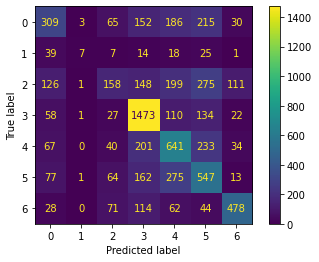

In [106]:
output.plot()

In [107]:
y_test

array(['happy', 'happy', 'happy', ..., 'disgust', 'disgust', 'disgust'],
      dtype='<U8')

In [113]:
ohe.get_feature_names_out()

array(['x0_angry', 'x0_disgust', 'x0_fear', 'x0_happy', 'x0_neutral',
       'x0_sad', 'x0_surprise'], dtype=object)